In [113]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import os
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from pathlib import Path
import random
import requests 
import zipfile
import pathlib
from PIL import Image
import kagglehub
from PIL import Image
import matplotlib.pyplot as plt

In [114]:
print(torch.__version__)

2.7.1+cpu


In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
train_dataset = datasets

In [117]:
data_path  = kagglehub.dataset_download("janmejaybhoi/cotton-disease-dataset")
print("Path: ",data_path)

Path:  C:\Users\user\.cache\kagglehub\datasets\janmejaybhoi\cotton-disease-dataset\versions\1


In [118]:
data_path = "data/Cotton Disease"

def Image_Lists(directory):
  L_images = []
  for dirpath,dirnames,filenames in os.walk(directory):
    for filename in filenames:
      if filename.lower().endswith((".png",".jpg","jpeg")):
        image_path = os.path.join(dirpath,filename)
        L_images.append({
          "path":image_path,
      }
      )
  return L_images

In [119]:
train_dir = "data/Cotton Disease/train"
test_dir = "data/Cotton Disease/test"
val_dir = "data/Cotton Disease/val"

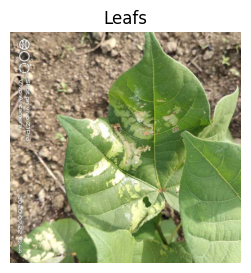

=== Image Infomation ===
Size :  (691, 691)


In [120]:
random_image = Image_Lists(directory=train_dir)
one_image = random.choice(random_image)

image = Image.open(one_image["path"]).convert("RGB")
plt.figure(figsize=(5,3))
plt.imshow(image)
plt.title('Leafs')
plt.axis("off")
plt.show()


print("=== Image Infomation ===")
print("Size : ", image.size)

In [121]:
Image_Transformer = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((64,64)),
  transforms.RandomRotation(degrees=15),
])

In [122]:
train_set = ImageFolder(root=train_dir,
                        target_transform=None,
                        transform=Image_Transformer)
test_set = ImageFolder(root=test_dir,
                        target_transform=None,
                        transform=Image_Transformer)
val_set = ImageFolder(root=val_dir,
                      target_transform=None,
                      transform=Image_Transformer)



train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset = test_set,batch_size=32,shuffle=True)
val_dir = DataLoader(dataset = val_dir,batch_size=32,shuffle=True)



In [123]:
test_loader

In [124]:
indexes = train_set.class_to_idx
print(f"Your Image Indexes : {indexes}")

Your Image Indexes : {'diseased cotton leaf': 0, 'diseased cotton plant': 1, 'fresh cotton leaf': 2, 'fresh cotton plant': 3}


In [125]:
class IMG_CLASSIFIER_MODEL(nn.Module):
  
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.block = nn.Sequential(
      nn.Conv2d(in_channels=input_size,out_channels=hidden_size,kernel_size=3,stride=1,padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_size,out_channels=hidden_size,kernel_size=3,stride=1,padding=0),
      nn.MaxPool2d((2,2))
    ) 

    with torch.no_grad():
      dummy = torch.zeros(1,input_size,64,64)
      dummy_out = (self.block(dummy))
      flattened_size = dummy_out.view(1, -1).size(1)
    
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=flattened_size,out_features=output_size)
    )
  
  def forward(self,x):
    x = self.block(x)
    x = self.classifier(x)
    return x

In [126]:
model = IMG_CLASSIFIER_MODEL(input_size=3,
                             hidden_size=10,
                             output_size=len(indexes))
model

IMG_CLASSIFIER_MODEL(
  (block): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9000, out_features=4, bias=True)
  )
)

In [132]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)


In [128]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_pred,y_true).sum().item()
  percent = (correct / len(y_pred))*100
  return percent

In [129]:
def train_loop(data_loader,train_model,loss_fn,optimizer):
  train_loss = 0 
  for i,data in enumerate(data_loader):
    features,target = data
    optimizer.zero_grad()
    outputs = train_model(features)
    loss = loss_fn(outputs,target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(data_loader)
  return train_loss

In [130]:
def testing_loop(data_loader,test_model,loss_fn,accuracy_fn):
  test_loss = 0 
  test_acc = 0
  with torch.inference_mode():
    for features,target in data_loader:
    
      outputs = test_model(features)
      test_loss += loss_fn(outputs,target)
      test_acc += accuracy_fn(y_true=target,y_pred=outputs.argmax(dim=1))

    test_loss/= len(data_loader)
    test_acc /= len(data_loader)
    return test_loss,test_acc

Epochs : 1
Test Loss :0.8913695812225342 || Train Loss : 0.8999195919662225 || Acc : 61.875
Epochs : 2
Test Loss :0.8760726451873779 || Train Loss : 0.7763322669951642 || Acc : 69.0625
Epochs : 3
Test Loss :0.6582684516906738 || Train Loss : 0.717478907499157 || Acc : 76.25
Epochs : 4
Test Loss :0.6059403419494629 || Train Loss : 0.6478461887015671 || Acc : 77.96875
Epochs : 5
Test Loss :0.6772453784942627 || Train Loss : 0.6025696851190974 || Acc : 74.6875
Epochs : 6
Test Loss :0.5735511183738708 || Train Loss : 0.5453987106925151 || Acc : 80.3125
Epochs : 7
Test Loss :0.7855024337768555 || Train Loss : 0.5435013995795953 || Acc : 73.4375
Epochs : 8
Test Loss :0.599992036819458 || Train Loss : 0.511661667804249 || Acc : 77.8125


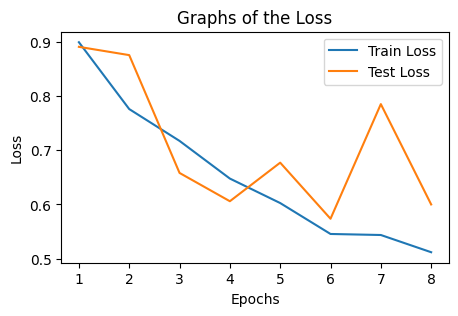

In [133]:
epochs_1 = 8

from tqdm import tqdm
import matplotlib.pyplot as plt


train_plot_values = []
test_plot_values = []

for epoch in (range(epochs_1)):
  print(f"Epochs : {epoch+1}")
  train_loss_new = train_loop( data_loader=train_loader,
                            train_model=model,
                             loss_fn=loss,
                             optimizer=optimizer
                             )
  test_loss_new,test_acc_new = testing_loop(data_loader=test_loader,
                            test_model=model,
                                    loss_fn=loss,
                                    accuracy_fn=accuracy_fn,
                                   )
  print(f"Test Loss :{test_loss_new} || Train Loss : {train_loss_new} || Acc : {test_acc_new}")
  train_plot_values.append(train_loss_new)
  test_plot_values.append(test_loss_new)


plt.figure(figsize=(5,3))
plt.plot(range(1, epochs_1+1), train_plot_values, label='Train Loss')
plt.plot(range(1, epochs_1+1), [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in test_plot_values], label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Graphs of the Loss")
plt.show()


In [ ]:
print(test_loader)

In [154]:
indexes = {v: k for k , v in indexes.items()}

In [155]:
def predict_Images(img,models,transformer):
  image = Image.open(img).convert("RGB")
  image  = transformer(image)
  image = image.unsqueeze(0)

  model.eval()
  with torch.no_grad():
    output = models(image)
    _,preds = torch.max(output,dim=1)
  print(f"This is the result without the mdoels {torch.max(output,dim=1)}")
  return indexes[preds[0].item()]

In [156]:
store_values = predict_Images(transformer=Image_Transformer,img=one_image["path"],models=model)
store_values

This is the result without the mdoels torch.return_types.max(
values=tensor([3.2634]),
indices=tensor([0]))


'diseased cotton leaf'

In [153]:
indexes

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [157]:
one_image

{'path': 'data/Cotton Disease/train\\diseased cotton leaf\\dis_leaf (88)_iaip.jpg'}